## 验证：  
使用加利福尼亚州住房数据集，尝试根据 1990 年的人口普查数据在城市街区级别预测 median_house_value。

In [27]:
#设置，加载数据并准备数据，使用多个特征，将逻辑模块化，以对特征进行预处理。
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
#设置pandas显示数据的格式
#读取csv数据

california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")
california_housing_dataframe.describe()
#随机化数据
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

### 预处理数据模块  

In [28]:
def preprocess_features(california_housing_dataframe):
#特征预处理
#选择除了median_house_value以外的所有特征，并创建合成特征：
#输入：california_housing_dataframe:包含输入数据的pandas Dataaframe.  
#返回：包含模型将要使用的特征以及合成特征的Dataframe。
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
#创建一个合成特征 
    processed_features["rooms_per_person"] = (
      california_housing_dataframe["total_rooms"] / 
      california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    #目标预处理
    #输出：包含目标特征的Dataframe
    
    output_targets = pd.DataFrame()
    #将目标缩放美元的1000分之1.
    output_targets["median_house_value"] = (
      california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

从17000个样本中选择前12000个样本作为**训练集**。

In [29]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2637.6,538.2,1429.7,500.2,3.9,2.0
std,2.1,2.0,12.6,2138.3,414.7,1152.6,377.0,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1470.0,297.0,790.0,282.8,2.6,1.5
50%,34.2,-118.5,29.0,2131.0,435.0,1168.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3148.2,648.0,1722.0,606.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


In [30]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.4
std,115.8
min,15.0
25%,119.9
50%,180.6
75%,265.0
max,500.0


对于**验证集**，从17000个样本中选择后5000个样本。

In [31]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2658.3,542.4,1429.3,503.6,3.9,2.0
std,2.1,2.0,12.7,2277.0,437.5,1136.6,401.9,1.9,1.0
min,32.5,-124.3,2.0,18.0,4.0,3.0,4.0,0.5,0.1
25%,33.9,-121.8,18.0,1435.8,296.0,788.0,279.0,2.6,1.5
50%,34.3,-118.5,29.0,2119.0,431.0,1162.5,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3159.0,651.2,1718.0,603.2,4.7,2.3
max,41.9,-114.5,52.0,30405.0,4952.0,12873.0,4616.0,15.0,29.4


In [32]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,207.1
std,116.5
min,15.0
25%,118.8
50%,179.5
75%,265.0
max,500.0


### 绘制经纬度与房屋价值中位数的曲线图  


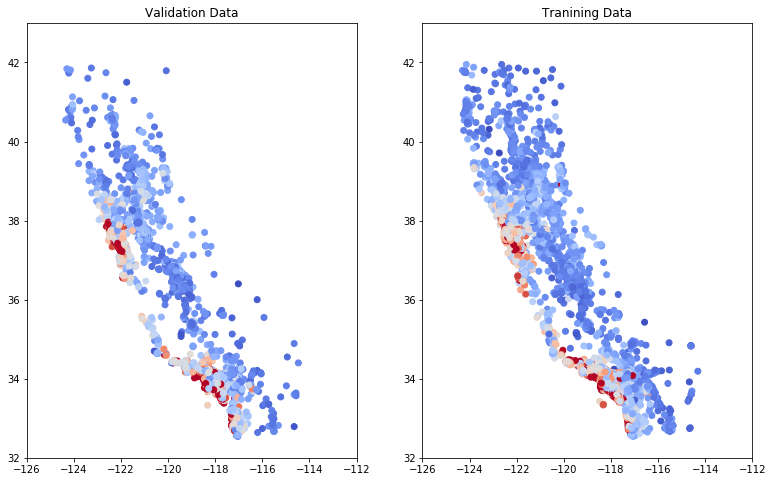

In [33]:
#设置figure大小
plt.figure(figsize=(13,8))

ax = plt.subplot(1,2,1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
#设置x,y轴范围
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap = "coolwarm",
            c = validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Tranining Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap = "coolwarm",
            c = training_targets["median_house_value"] / training_targets["median_house_value"].max())

### 设置输入函数：  

In [49]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    #将pandas数据转换为一个np数组的dict
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    #构建一个数据集，并且配置batching/repeating
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    #特别地，对数据重新洗牌
    if shuffle:
        ds = ds.shuffle(10000)
        
    #返回数据的下一个batch
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels
    

由于使用的是多个特征作为输入，因此需要把用于将特征列配置为独立函数的代码模块化。

In [50]:
def construct_feature_columns(input_features):
    #构建Tensorflow特征列
    #输入特征：将要使用的数值特征的名称
    #返回：特征列集合
    return set([tf.feature_column.numeric_column(my_feature)
               for my_feature in input_features])

# 训练模型  


In [51]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10
    steps_per_period = steps / periods
  
  # 创建一个线性回归对象，配置线性回归分类器.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )
  
  # 1. 创建输入函数.
    training_input_fn = lambda: my_input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn =  lambda: my_input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
  
  # 训练模型，但是内置一个循环来使得我们可以周期性的评估损失矩阵
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
    # 从之前的状态开始训练模型
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
    # 2. 暂停一下计算预测
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # 计算训练和验证损失.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
    # 间或输出当前损失.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # 增加该周期的损失矩阵到我们的列表.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

  # 输出这个周期下的损失矩阵的图.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 221.31
  period 01 : 206.49
  period 02 : 193.40
  period 03 : 182.57
  period 04 : 175.29
  period 05 : 169.13
  period 06 : 167.18
  period 07 : 165.70
  period 08 : 165.64
  period 09 : 166.19
Model training finished.


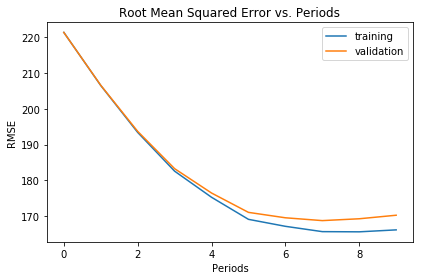

In [58]:
linear_regressor = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    learning_rate=0.00003,
    steps=400,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 基于测试集数据进行模型的评估

In [60]:
california_housing_test_data = pd.read_csv("california_housing_test.csv", sep=",")
#
# YOUR CODE HERE
#
test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda:my_input_fn(test_examples, test_targets["median_house_value"], num_epochs=1, shuffle=False)


test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
  metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 161.13
